# 個別画像のモジュール検出

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# モジュールのインポート
import os
import json
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import sys
import pickle

In [3]:
# 自作モジュール
sys.path.append("../src")
import module_extraction
from module_extraction import Filters, Modules
import utils

分析対象の指定

In [4]:
# --個別画像 --
input_img_path = '../images/ortho/27.JPG'

In [5]:
# 出力先フォルダの作成
output_dir_path = "../outputs/"+input_img_path.split("/")[-1][:-4]
print(output_dir_path)
os.makedirs(output_dir_path,exist_ok=True)

../outputs/27


フィルタの適用

In [6]:
filters = Filters()

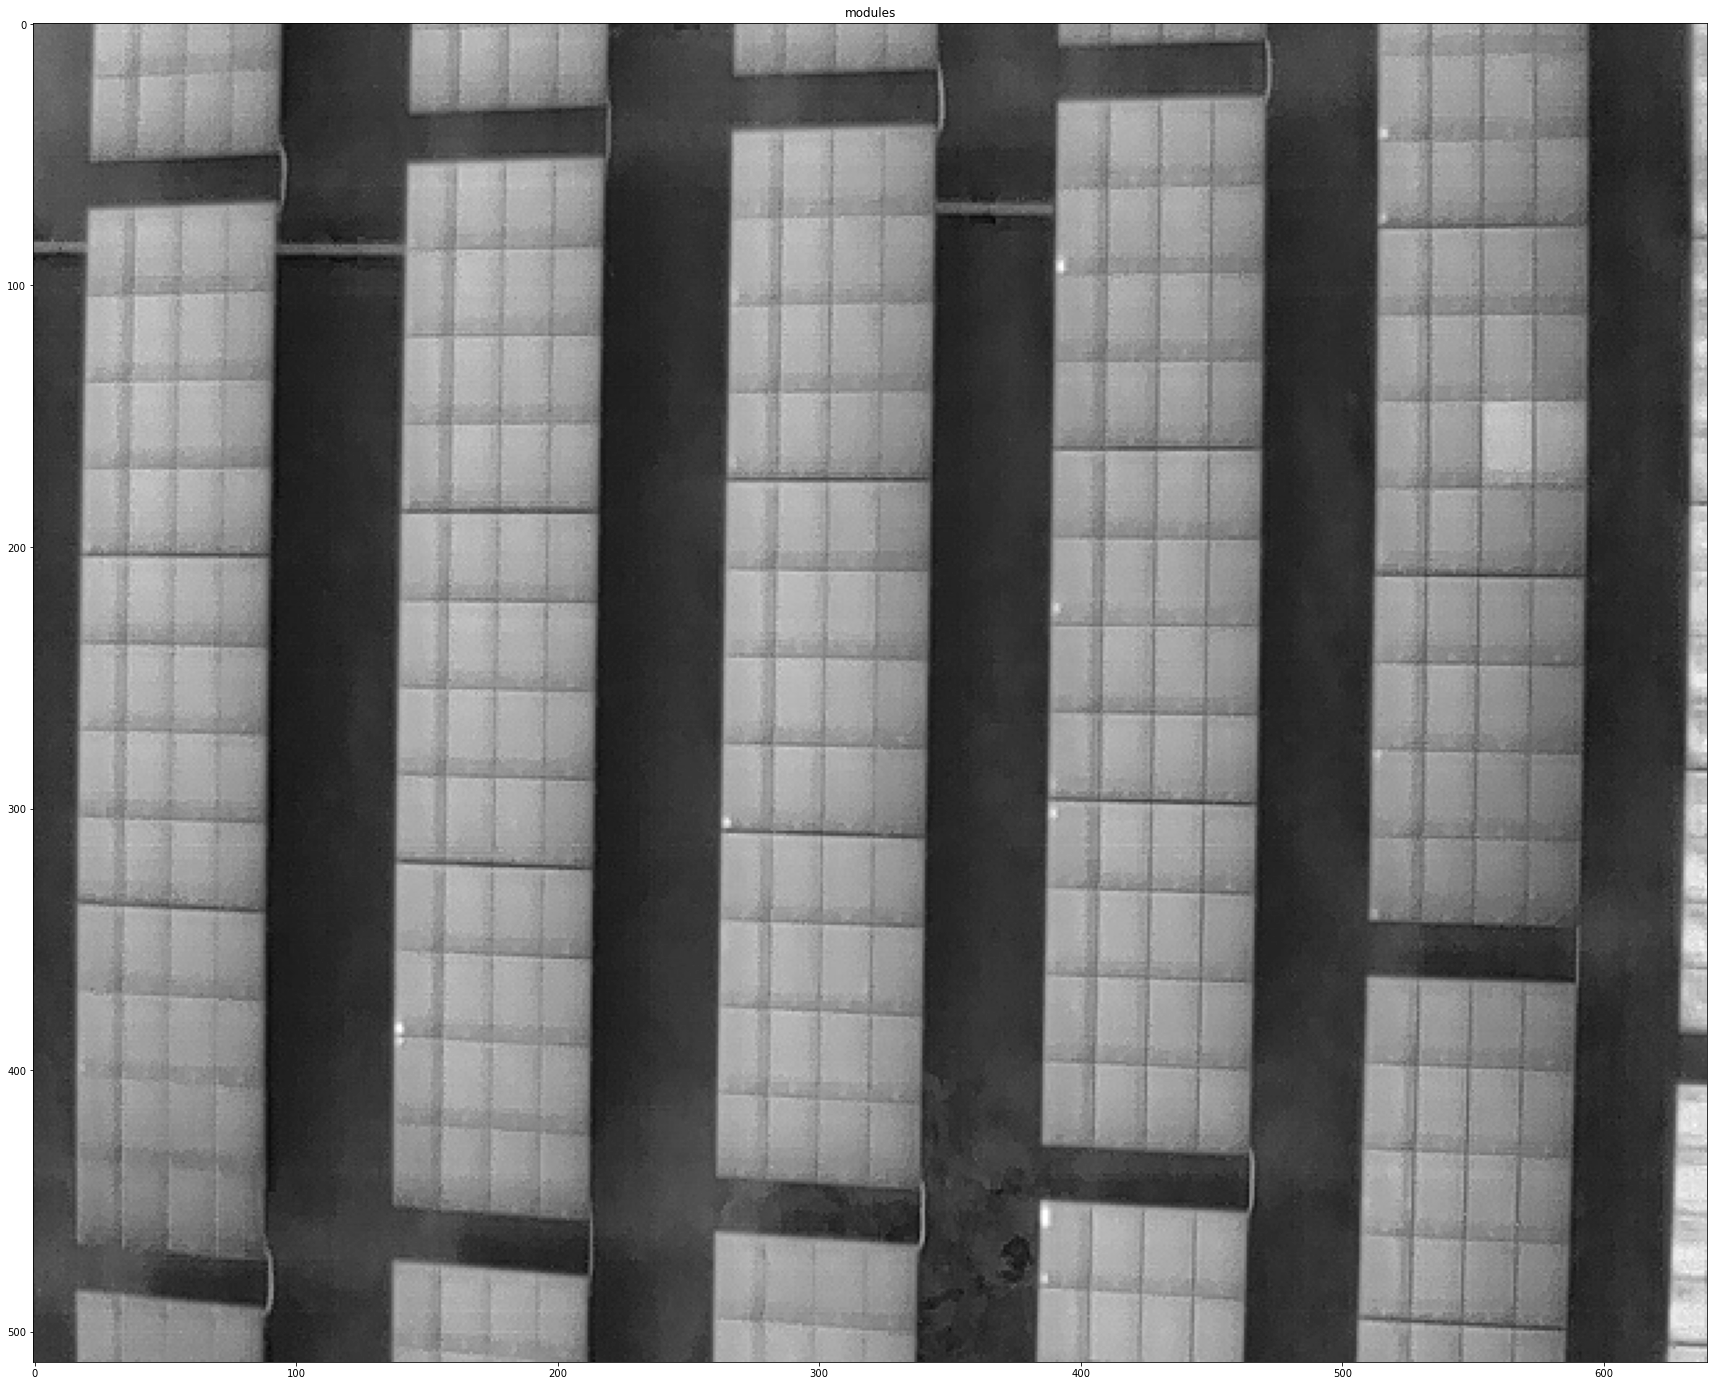

In [7]:
# 元画像
img_org = cv2.imread(input_img_path, 0)
utils.show_img({"modules":img_org},cmap="gray",figsize=(30,30))

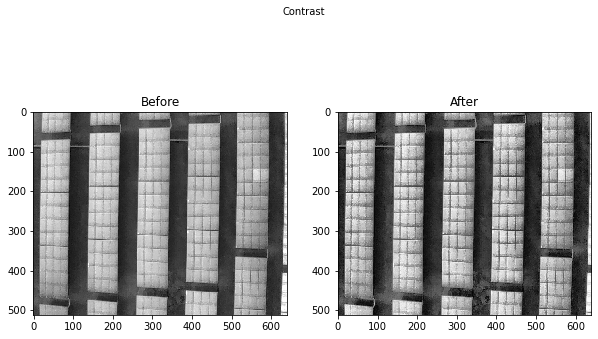

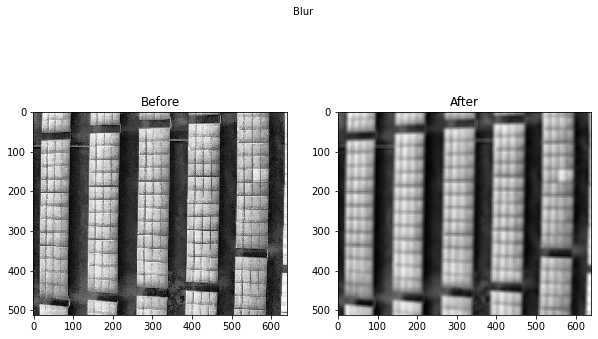

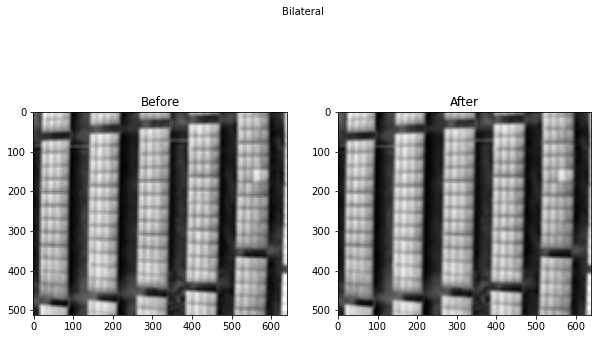

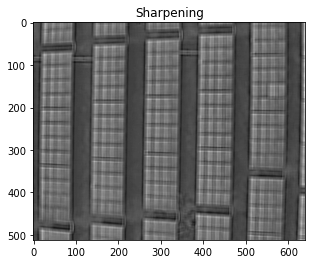

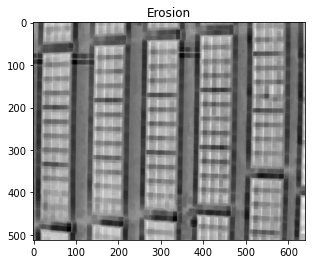

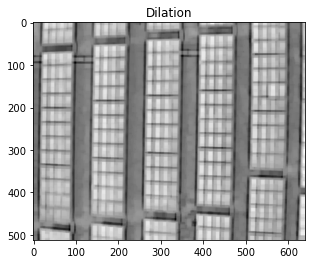

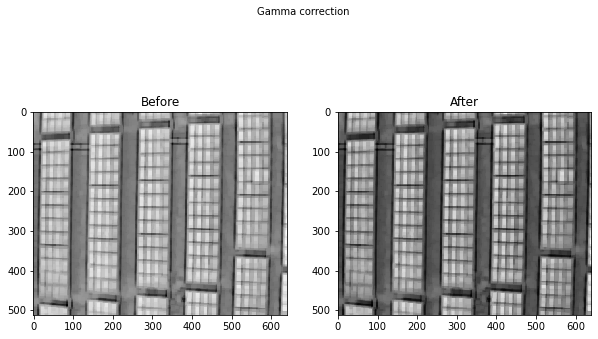

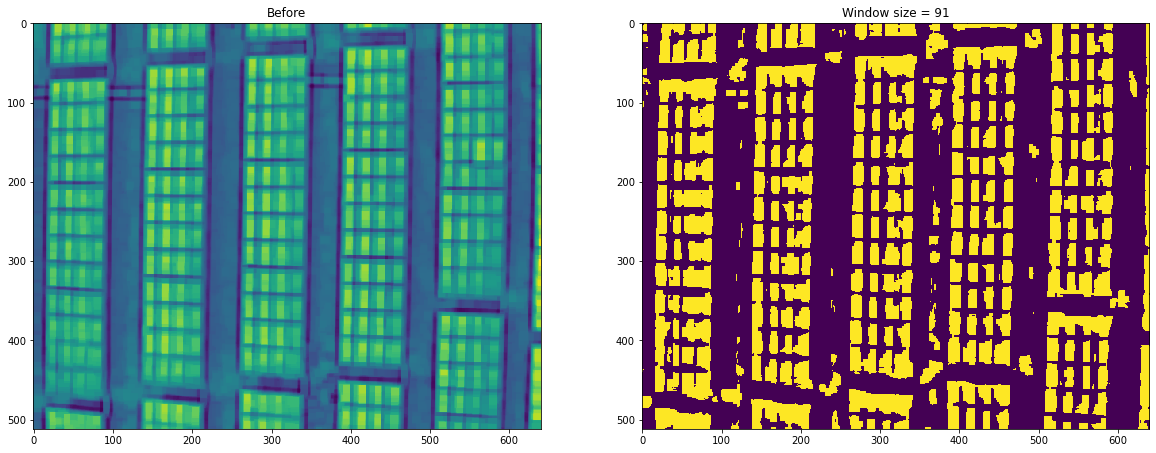

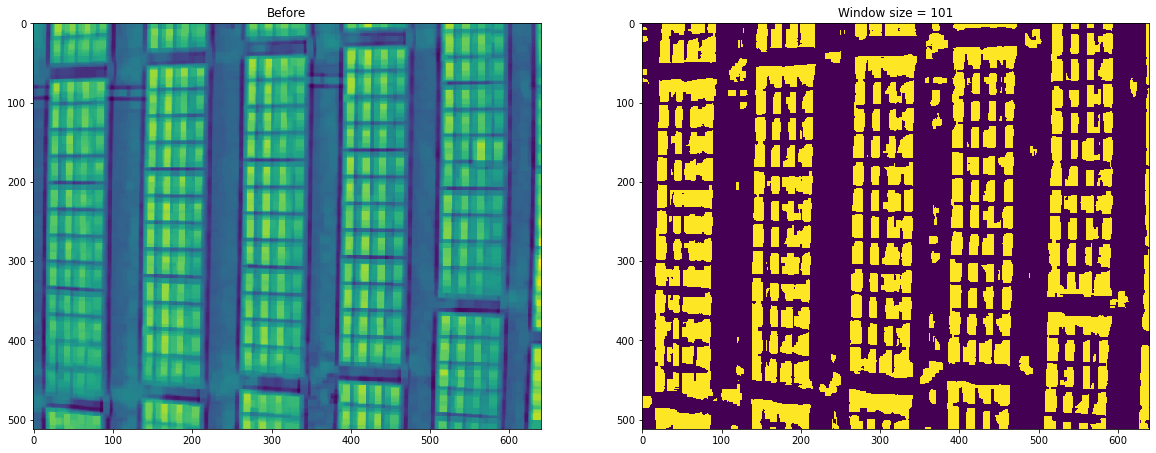

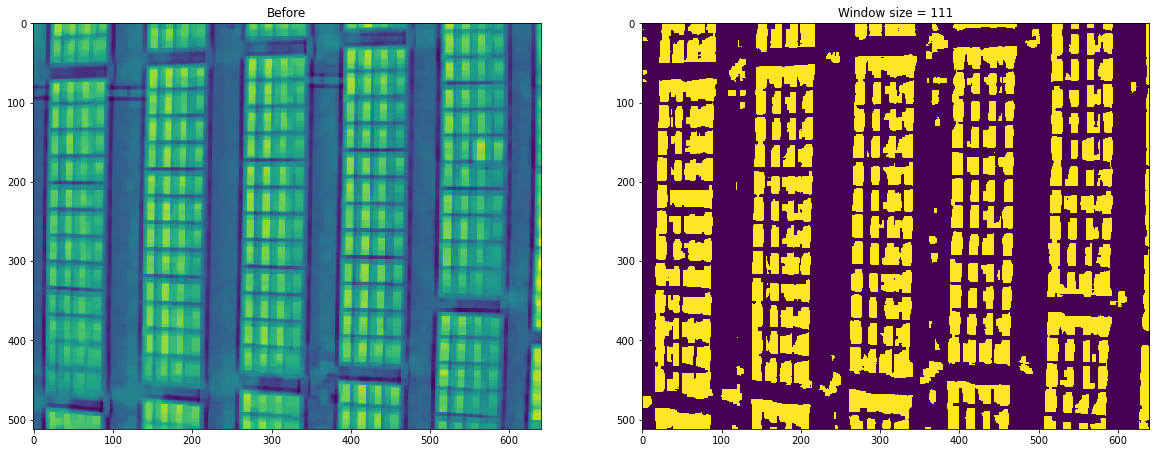

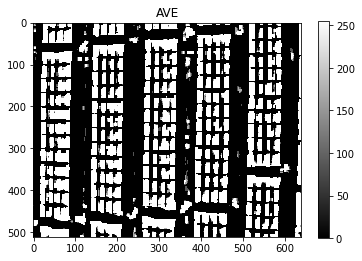

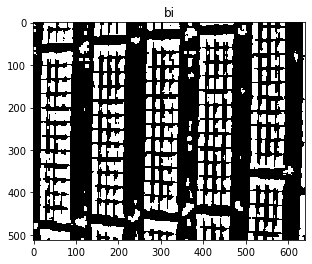

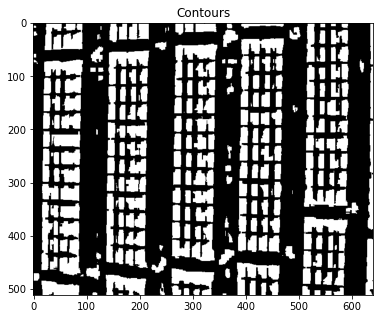

[array([[ 35, 204],
       [ 88, 204],
       [ 88, 233],
       [ 35, 233]]), array([[21, 49],
       [24, -1],
       [53,  0],
       [50, 51]])]


In [8]:
# 前処理
candidate_module_contours = filters.get_module_contours(img_org)
print(candidate_module_contours)

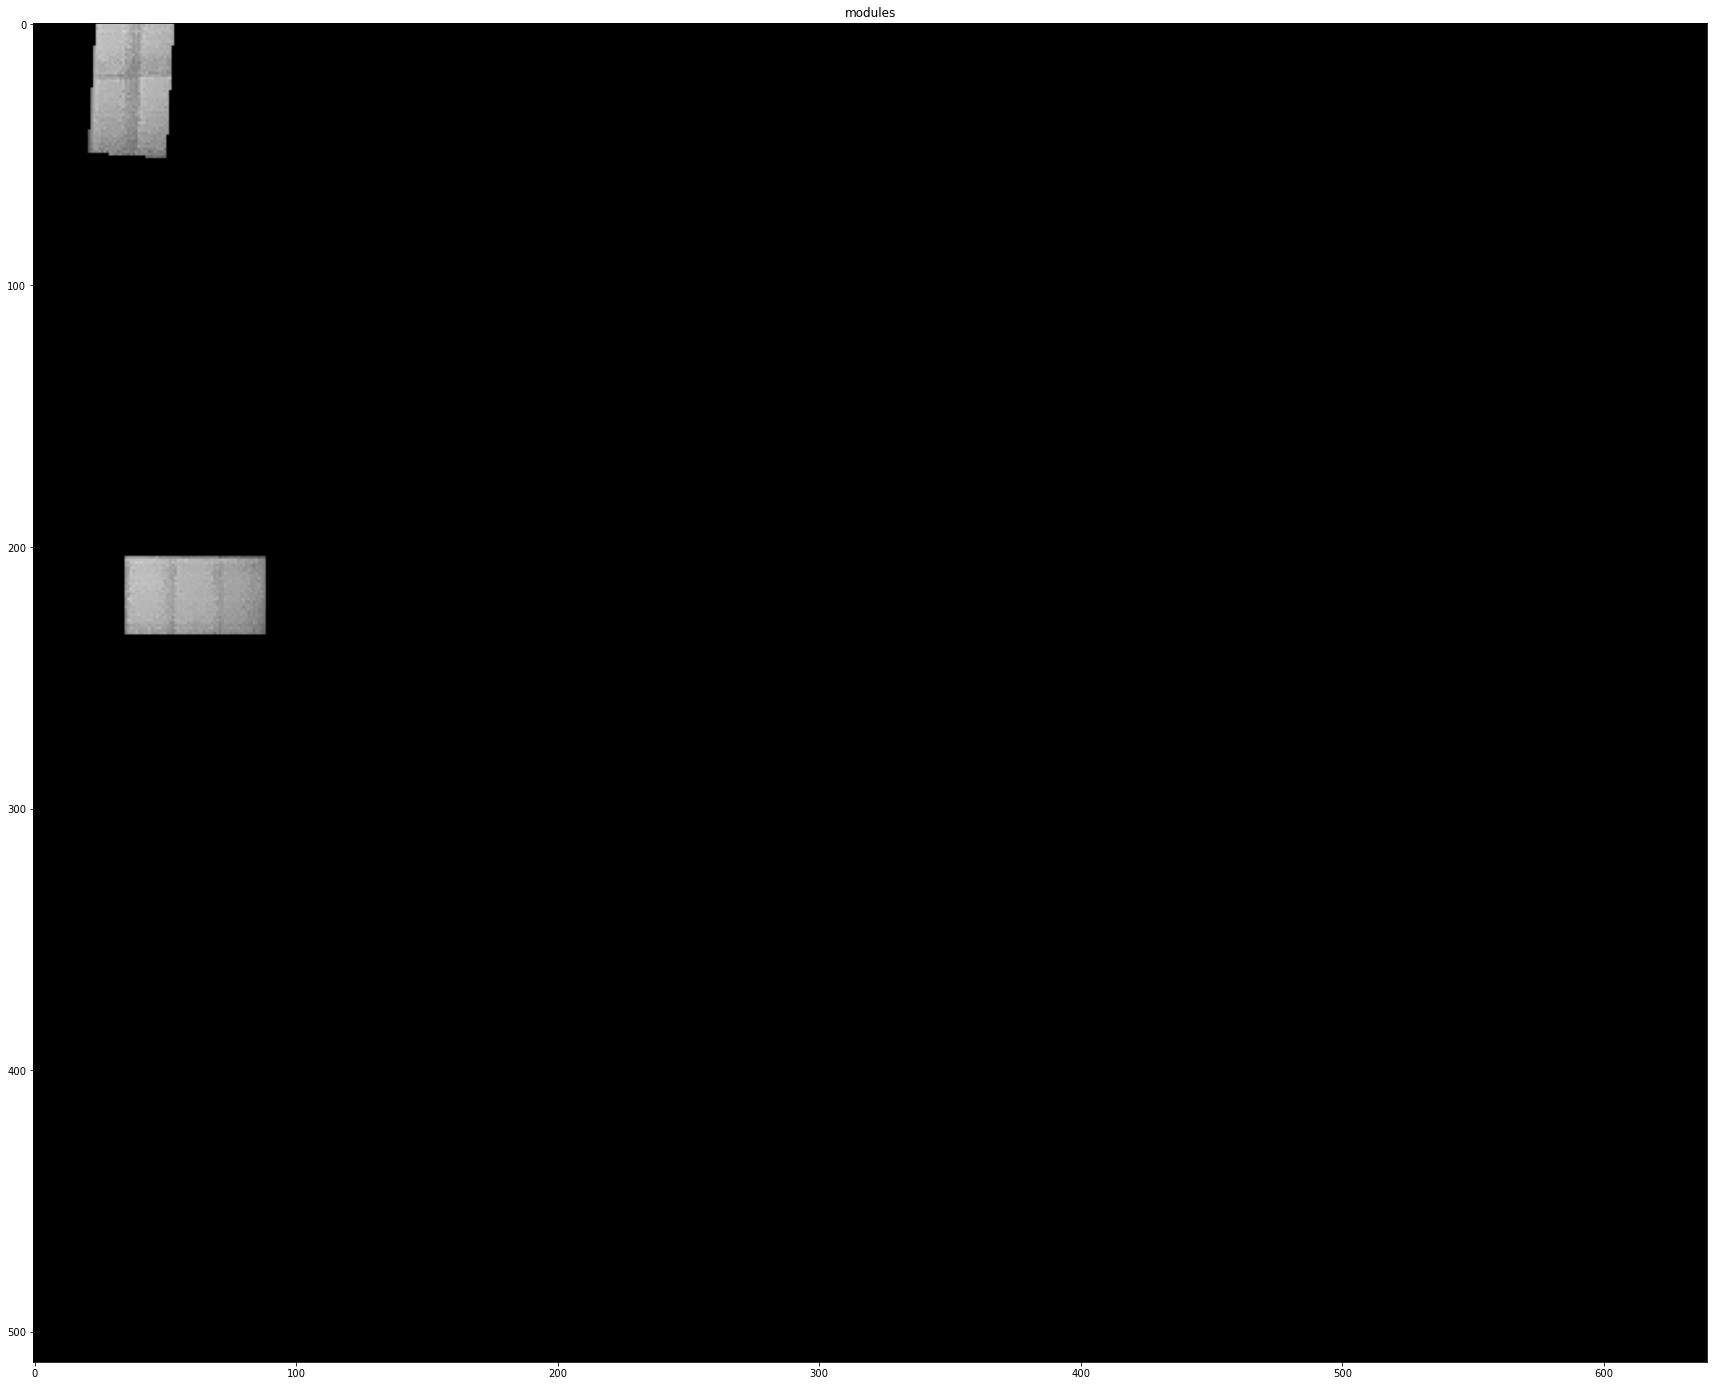

In [9]:
# モジュール抽出画像
img_con = cv2.drawContours(np.zeros_like(img_org), candidate_module_contours, -1, 255, -1)
img_mask = cv2.bitwise_and(img_org, img_con)
utils.show_img({"modules":img_mask},cmap="gray",figsize=(30,30))

In [10]:
# 画像の出力
img_write = cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB)
cv2.imwrite(output_dir_path+'/img_mask_index_no_dbscan.png',img_write)

True

モジュール候補のクラスタリング

In [11]:
# クラスタのラベルを取得
modules = Modules(candidate_module_contours)
module_labels = modules.get_dbscan_labels(candidate_module_contours, eps=1.25)
print(module_labels[0:300])

[-1 -1]


IndexError: list index out of range

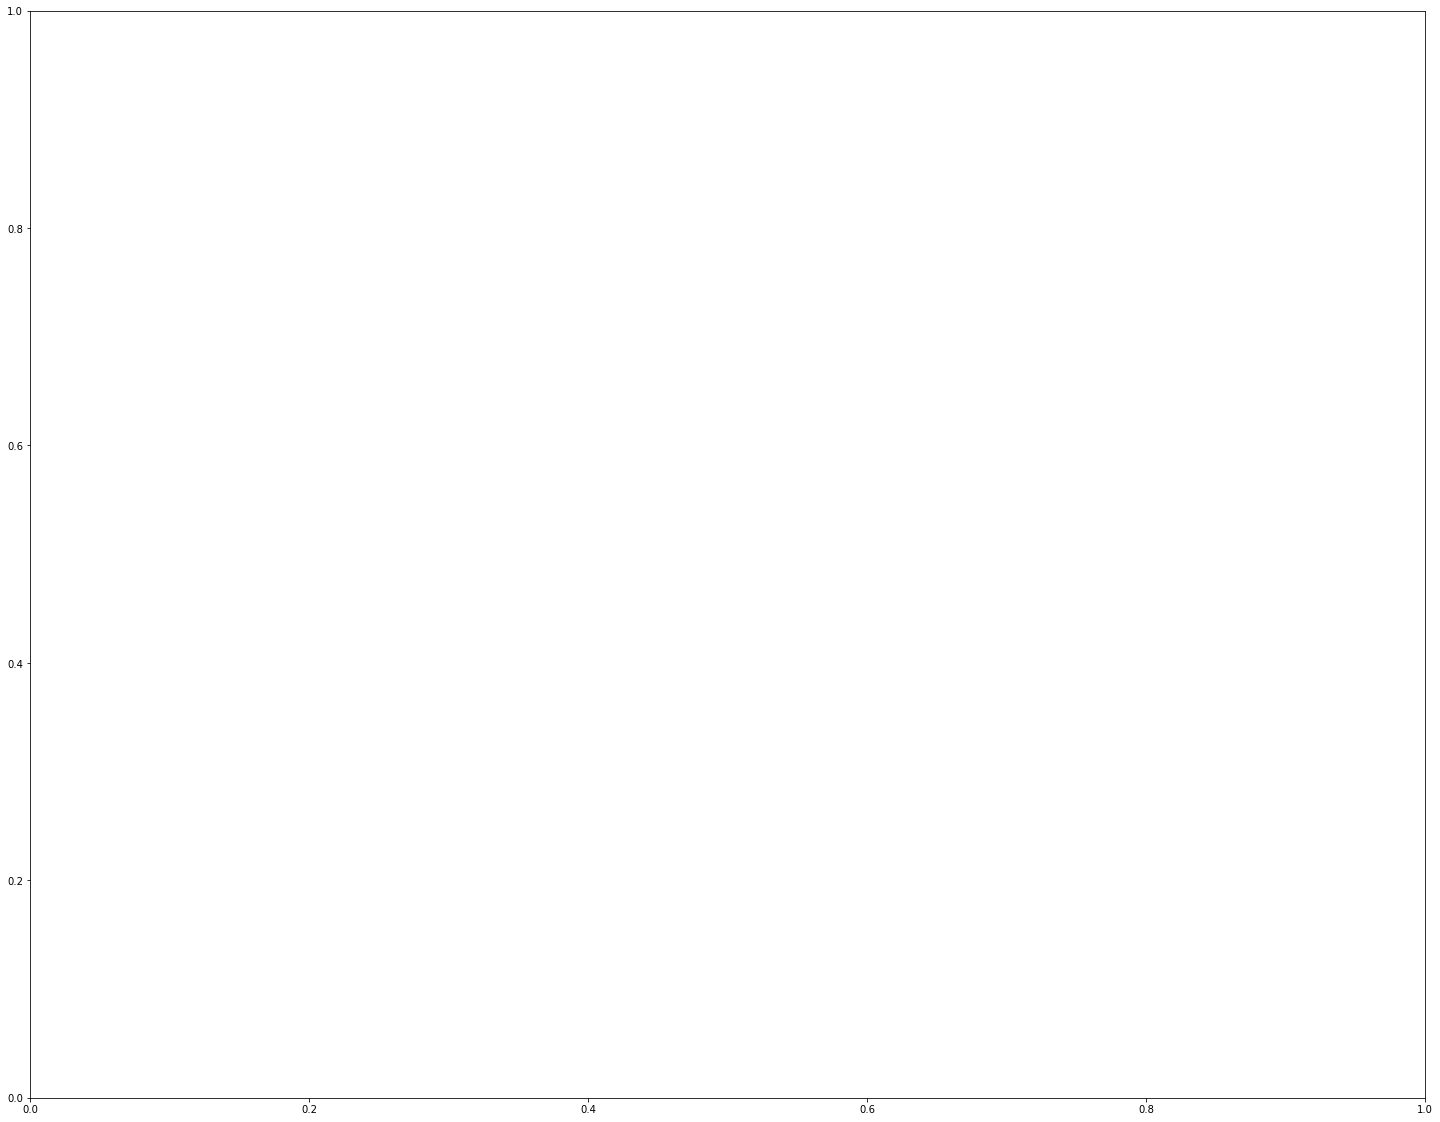

In [12]:
module_extraction.plot_module_map_with_labels(img_org, candidate_module_contours, module_labels)

サイズが大きいクラスタのみを残す

In [13]:
from collections import Counter
counter = Counter(module_labels)

In [14]:
counter.most_common

<bound method Counter.most_common of Counter({-1: 2})>

In [15]:
n_threshold = 10
group_labels = np.array([i for (i, count) in counter.most_common() if i>0 and count>n_threshold ])
group_flags = [label in group_labels for label in module_labels]

サイズの大きいクラスタのみを残してクラスタリングを再実行

In [16]:
# クラスタのラベルを取得
module_contours = np.array(candidate_module_contours)[group_flags]
modules = Modules(module_contours) # 真のモジュール情報に更新
module_labels = modules.get_dbscan_labels(module_contours, eps=1.25)

/Users/afterfit946/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/afterfit946/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

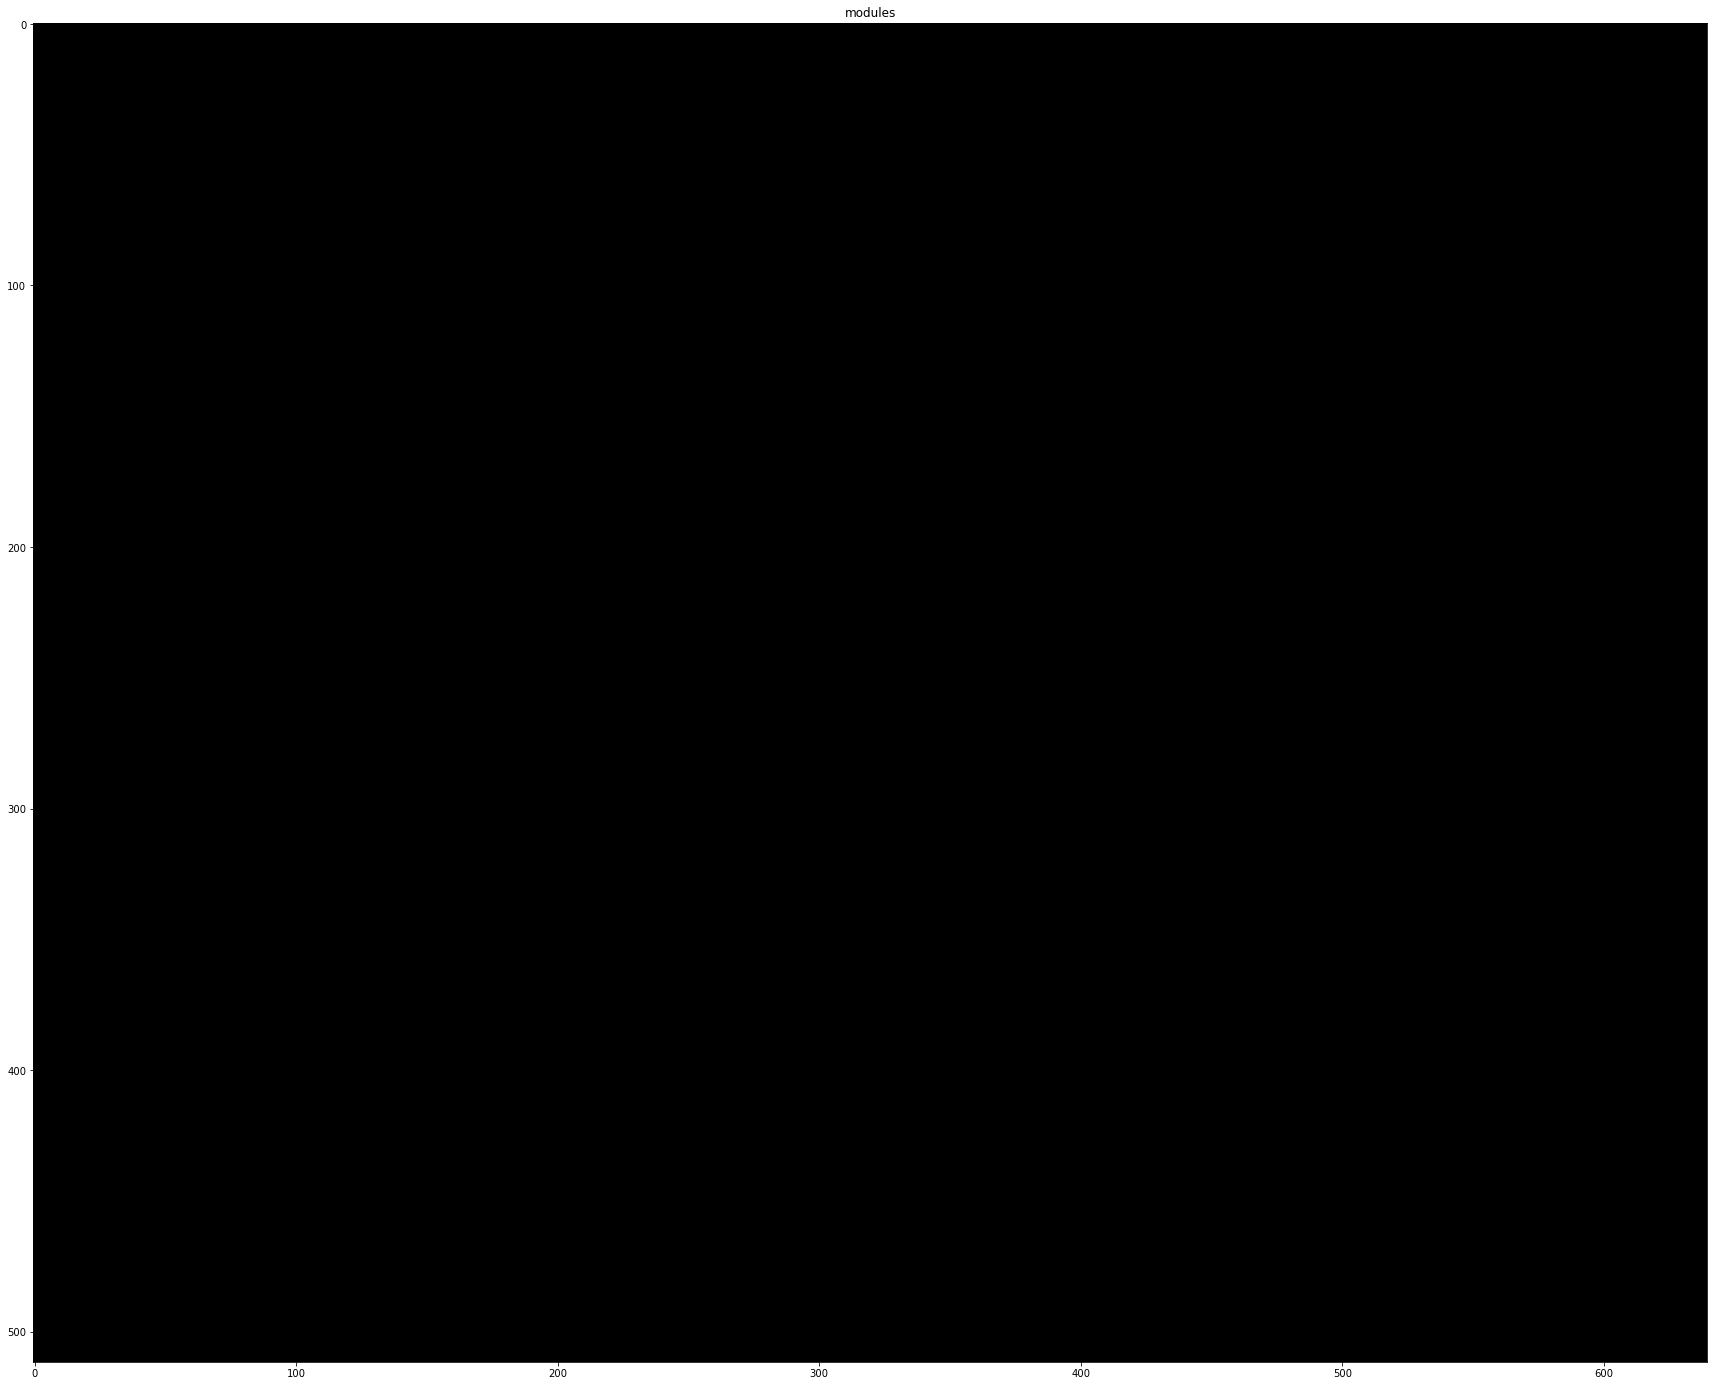

In [17]:
# モジュール抽出画像
img_con = modules.get_img_contours(img_org, index=False)
img_mask = cv2.bitwise_and(img_org, img_con)
img_mask_index = modules.add_index(img_mask)
utils.show_img({"modules":img_mask_index},cmap="gray",figsize=(30,30))

In [18]:
# 画像の出力
img_write = cv2.cvtColor(img_mask_index, cv2.COLOR_BGR2RGB)
cv2.imwrite(output_dir_path+'/img_mask_index.png',img_write)

True

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 2

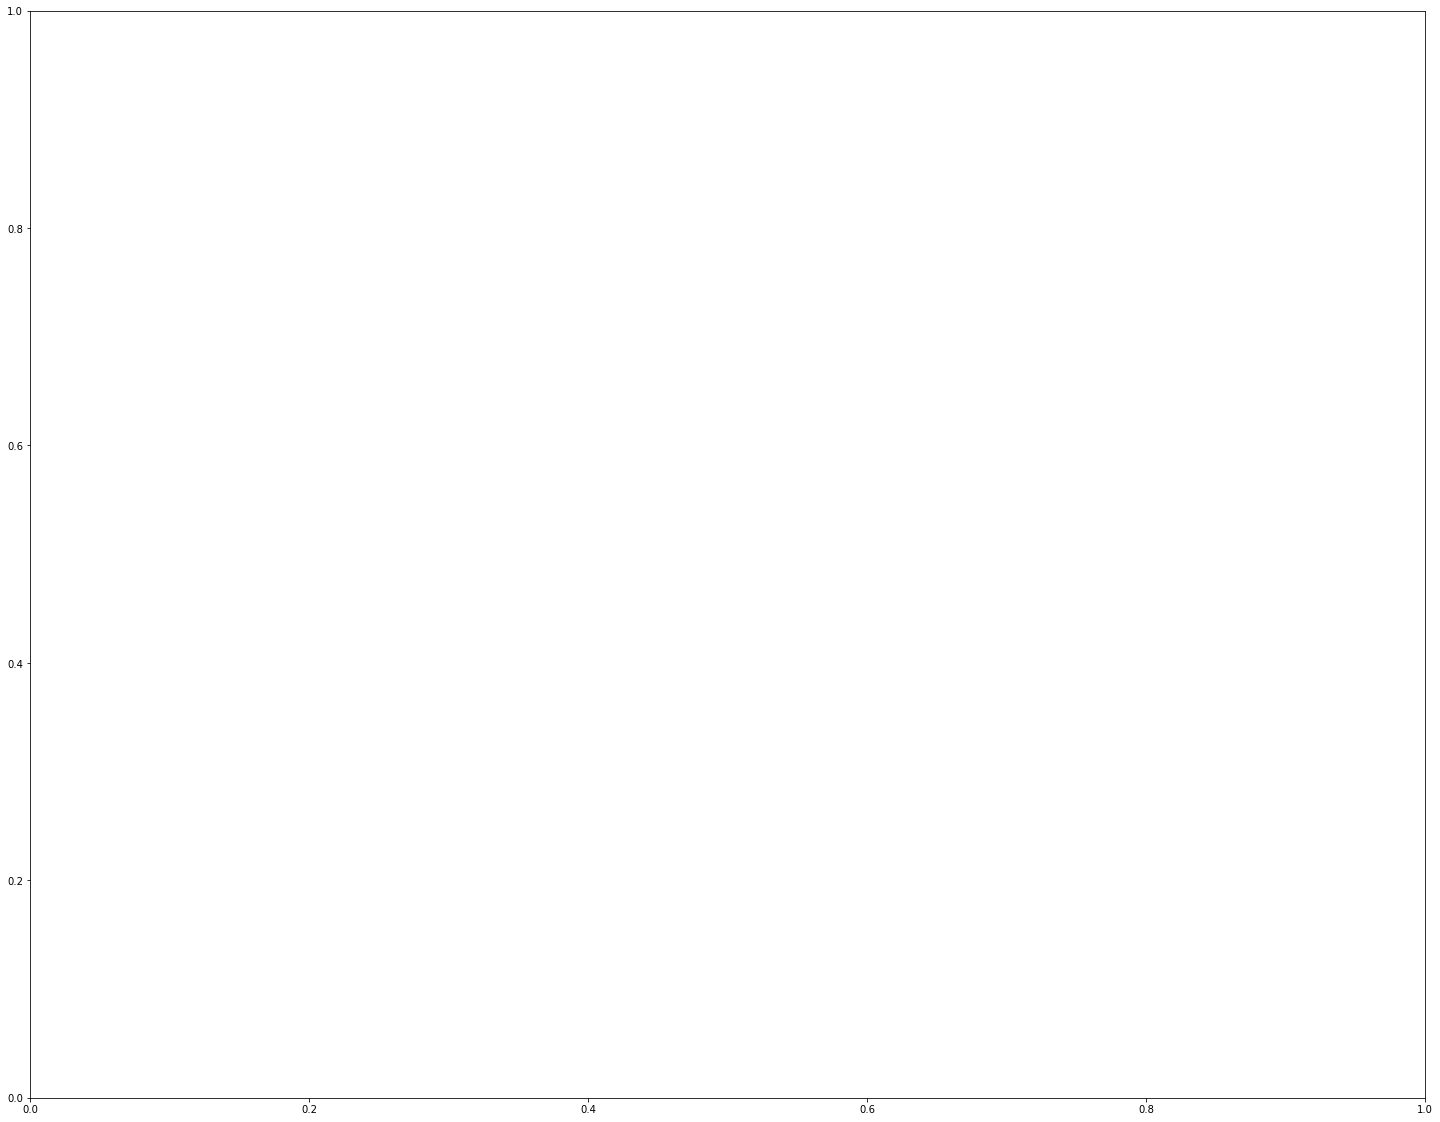

In [19]:
module_extraction.plot_module_map_with_labels(img_org, module_contours, module_labels)

クラスタサイズ調整のための再分割

In [20]:
desired_cluster_size = 50

In [21]:
splitted_module_labels = module_extraction.split_module_labels(
    module_contours, module_labels, desired_cluster_size)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 2

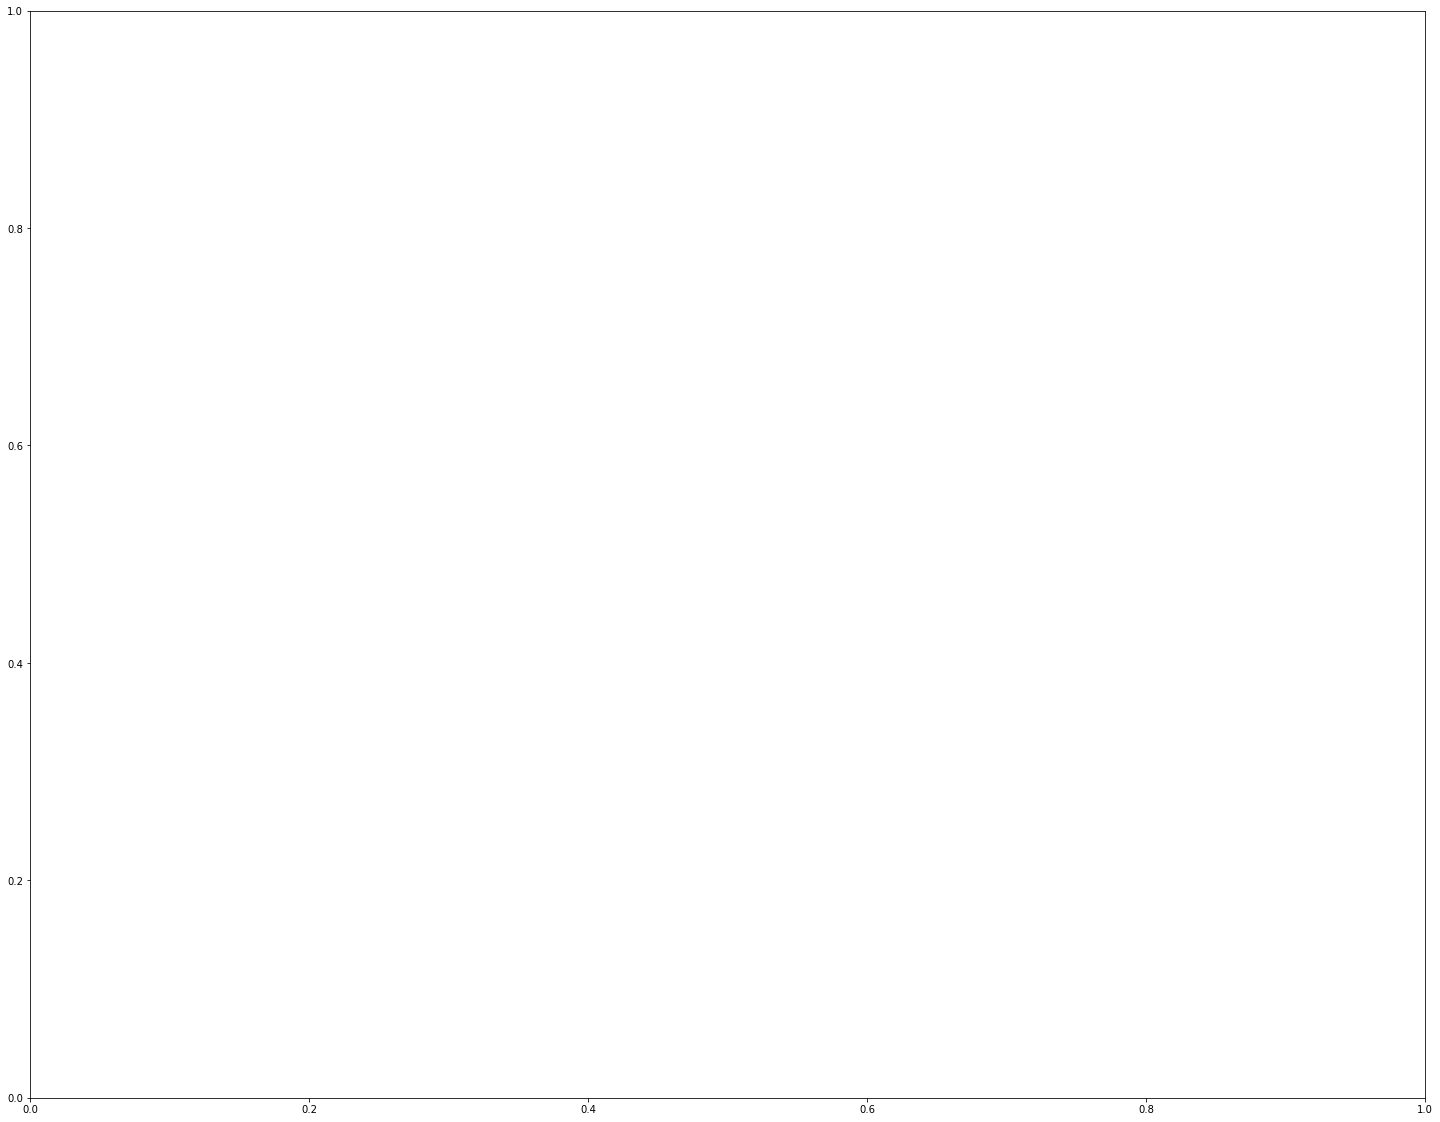

In [23]:
module_extraction.plot_module_map_with_labels(img_org, module_contours, splitted_module_labels)

モジュールデータの保存

In [24]:
# モジュール画像の切り出し＆保存
modules.extract_modules(img_org, output_dir_path)

In [25]:
# モジュール輪郭情報とラベルの保存
with open(output_dir_path+'/module_contours.pkl', 'wb') as pkl:
    pickle.dump(module_contours, pkl)
with open(output_dir_path+'/module_labels.pkl', 'wb') as pkl:
    pickle.dump(module_labels, pkl)    
with open(output_dir_path+'/module_labels_split.pkl', 'wb') as pkl:
    pickle.dump(splitted_module_labels, pkl)    